In [6]:
import os
import yaml
import pickle
import matplotlib
from multiprocessing import Pool

import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.ticker as ticker
import torchvision
from scipy import stats
import matplotlib.pyplot as plt
from bilby.gw.detector import InterferometerList
from bilby.gw.detector import PowerSpectralDensity
from tqdm.notebook import tqdm_notebook
import torch
from pprint import pprint
import seaborn as sns
from ipywidgets import *
import pandas as pd

matplotlib.use('pdf')
os.environ['MPLCONFIGDIR'] = '/home/local/nihargupte'
import dingo.gw.dataset.generate_dataset 
from dingo.gw.inference import injection
import dingo.gw.training.train_builders
import dingo.gw.waveform_generator
from dingo.gw.ASD_dataset.noise_dataset import ASDDataset
from dingo.gw.dataset import WaveformDataset
from dingo.gw.domains import build_domain, build_domain_from_model_metadata
import dingo.gw.inference
from dingo.gw.transforms import SelectStandardizeRepackageParameters, RepackageStrainsAndASDS, UnpackDict, SampleExtrinsicParameters, GNPECoalescenceTimes, AddWhiteNoiseComplex
from dingo.core.models import PosteriorModel
import dingo.gw.domains
from dingo.gw.inference.gw_samplers import GWSamplerGNPE, GWSampler

from utils import *

%load_ext autoreload
%autoreload 2
%matplotlib ipympl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
charizard_hex = ('#cd5241', '#084152', '#207394', '#eeb45a', '#e64110', '#ff524a', '#f6a410', '#08398b', '#626262', '#833118', '#eede7b')
plt.rcParams['text.usetex'] = False
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['font.size'] = 15
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=charizard_hex)

In [3]:
models_dir = "/home/local/nihargupte/dingo-devel/tutorials/03_aligned_spin"
waveform_generation_dir = (
    "/home/local/nihargupte/dingo-devel/tutorials/03_aligned_spin/datasets/waveforms"
)

seob_device = 0
# build posterior model
torch.cuda.set_device(seob_device)
main_pm_2048 = PosteriorModel(
    device="cuda",
    **{"model_filename": f"{models_dir}/train_dir_SEOBNRv4HM_ROM_O1/model_latest.pt"},
)
main_pm_2048.metadata["train_settings"]["training"]["stage_0"]["asd_dataset_path"] = "/home/local/nihargupte/dingo-devel/tutorials/03_aligned_spin/datasets/ASDs_new/1024_1/asds_O1.hdf5"

main_pm_1024 = PosteriorModel(
    device="cuda",
    **{
        "model_filename": f"{models_dir}/train_dir_SEOBNRv4HM_ROM_O1_1024/model_latest.pt"
    },
)

Putting posterior model to device cuda.
Putting posterior model to device cuda.


In [14]:
os.environ["LAL_DATA_PATH"] = "/home/local/nihargupte/dingo-devel/venv/lib/python3.9/site-packages/lalsimulation/"

# "mass_1": 38.9,
# "mass_2": 31.6,
# intrinsic_parameters = {
#     # intrinsic parameters
#     "mass_ratio": .9,# 0.8123393316195373,
#     "chirp_mass": 15, # 30.48907067184531,
#     "chi_1": 0.5,
#     "chi_2": 0.3,
# }
intrinsic_parameters = {
    # intrinsic parameters
    "mass_ratio": 0.8123393316195373,
    "chirp_mass": 30.48907067184531,
    "chi_1": 0.5,
    "chi_2": 0.3,
}

total_mass = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_total_mass(intrinsic_parameters["chirp_mass"], intrinsic_parameters["mass_ratio"])
mass_1, mass_2 = bilby.gw.conversion.total_mass_and_mass_ratio_to_component_masses(intrinsic_parameters["mass_ratio"], total_mass)
intrinsic_parameters = {
    **intrinsic_parameters,
    "mass_1": mass_1,
    "mass_2": mass_2
}

extrinsic_parameters = {
    "phase": 1.2,  # rad
    "theta_jn": 0,  # rad inclination to maximize effect of higher modes
    "psi": 0.7,  # rad
    "ra": 0.33,  # rad
    "dec": -0.6,  # rad
    "geocent_time": 0.0,  # s
    "luminosity_distance": 410,  # Mpc
}

asd_dataset = ASDDataset(file_name=main_pm_2048.metadata["train_settings"]["training"]["stage_0"]["asd_dataset_path"])
asd = asd_dataset.sample_random_asds()
asd = {k:v.astype(np.float128) for k,v in asd.items()}
theta = {**intrinsic_parameters, **extrinsic_parameters}

injection_generator_1024 = injection.Injection.from_posterior_model(main_pm_1024)
injection_generator_1024.asd = asd
strain_data_1024 = injection_generator_1024.signal(theta)

injection_generator_2048 = injection.Injection.from_posterior_model(main_pm_2048)
injection_generator_2048.asd = asd
strain_data_2048 = injection_generator_2048.signal(theta)


Loading dataset from /home/local/nihargupte/dingo-devel/tutorials/03_aligned_spin/datasets/ASDs_new/1024_1/asds_O1.hdf5.


In [18]:
ifos = InterferometerList(["H1", "L1"])
ifos.time_duration = 8.0
domain = build_domain_from_model_metadata(main_pm_1024.metadata)
for ifo in ifos:
    asd_array = injection_generator_1024.asd[ifo.name]
    # This step is actually very important
    asd_array = asd_array.astype("float64")
    x_freq = domain.sample_frequencies.astype("float64")
    psd = PowerSpectralDensity(frequency_array=x_freq, asd_array=asd_array)
    ifo.power_spectral_density = psd
    # Making sure we aren't dropping anything due to precision
    assert np.min(asd_array**2) > 0
    ifo.set_strain_data_from_frequency_domain_strain(strain_data_1024["waveform"][ifo.name], frequency_array=x_freq)
    ifo.strain_data.window_factor = domain.window_factor
    bilby_snr = np.sqrt(ifo.optimal_snr_squared(signal=strain_data_1024['waveform'][ifo.name]))
    dingo_snr = get_snr(injection_generator_1024.asd, strain_data_1024)[0][ifo.name]
    print(f"Bilby SNR {bilby_snr},    Dingo SNR {dingo_snr}")

Bilby SNR (8.397709268013106+0j),    Dingo SNR (8.130922964453982+0j)
Bilby SNR (13.156939518755086+0j),    Dingo SNR (12.738957525292943+0j)


: 

-0j
-0j
(-0+0j)
(-0+0j)


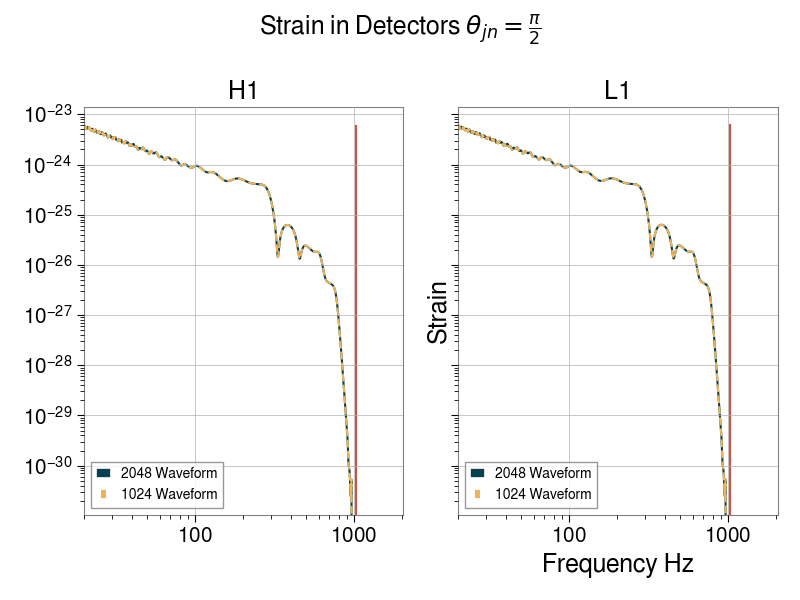

In [5]:
%matplotlib notebook
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8, 6))
fig.suptitle(r"Strain in Detectors $\theta_{jn} = \frac{\pi}{2}$")

for i, ifo_name in enumerate(["H1", "L1"]):
    print(strain_data_2048["waveform"][ifo_name][8192])
    print(strain_data_1024["waveform"][ifo_name][8192])
    axes[i].set_title(ifo_name)
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')
    axes[i].set_xlim([20, 2048])
    axes[i].plot([1024, 1024], [np.min(np.abs(strain_data_2048["waveform"][ifo_name])), np.max(np.abs(strain_data_2048["waveform"][ifo_name]))])
    axes[i].plot(injection_generator_2048.data_domain.sample_frequencies, np.abs(strain_data_2048["waveform"][ifo_name]), label="2048 Waveform")
    axes[i].plot(injection_generator_1024.data_domain.sample_frequencies, np.abs(strain_data_1024["waveform"][ifo_name]), linestyle='--', color=charizard_hex[3], label="1024 Waveform")
    axes[i].legend()

plt.xlabel("Frequency Hz")
plt.ylabel("Strain")
plt.tight_layout()
plt.savefig("/home/local/nihargupte/dingo-devel/tutorials/05_data_vis/dumps/strain_in_detectors.pdf")

1.5707963267948966
SNR 1024 {'H1': (2.5258705424513837557+0j), 'L1': (2.4438319164775677435+0j)}   and SNR 2048 {'H1': (2.52587054496700708+0j), 'L1': (2.4438319180180758184+0j)}
Detector SNR 1024 (3.5145890845471635+0j)   and SNR 2048 (3.5145890874262715+0j)
<class 'matplotlib.lines.Line2D'> Line2D(Optimal SNR per frequency bin)


/home/local/nihargupte/dingo-devel/venv/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


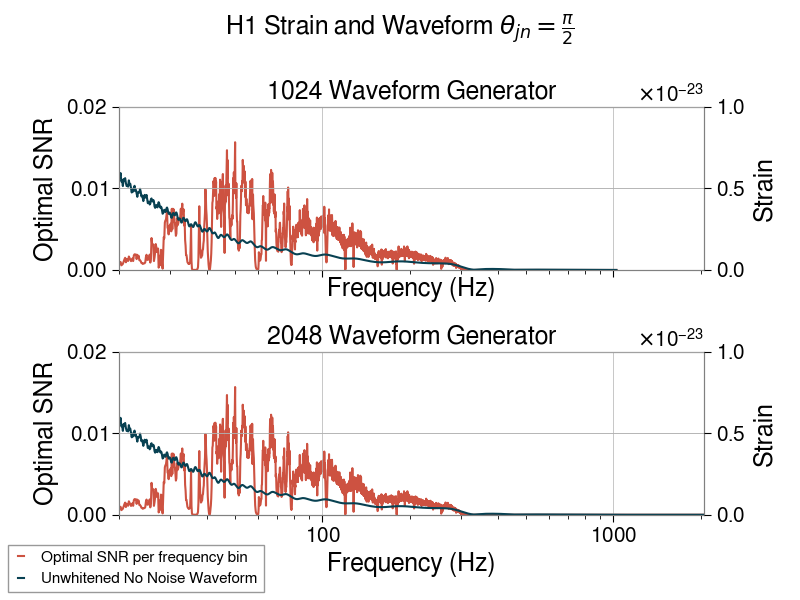

In [8]:
# Calculating SNR of injection
from bilby.gw.utils import noise_weighted_inner_product, optimal_snr_squared

fig, axes = plt.subplots(2, 1, figsize=(8,6), sharex=True)
fig.suptitle(r"H1 Strain and Waveform $\theta_{jn}= \frac{\pi}{2}$")

y_max = .02
y_max_wf = 1e-23
ax1 = axes[0]
ax1.set_title("1024 Waveform Generator")
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Optimal SNR")
ax1.set_ylim([0, y_max])
ax1.set_xlim([20, 2048])
ax1.set_xscale('log')
line_1, = ax1.plot(injection_generator_1024.data_domain.sample_frequencies, np.zeros(shape=injection_generator_1024.data_domain.sample_frequencies.shape[0]), label="Optimal SNR per frequency bin")
ax2 = ax1.twinx()
# ax2.set_yscale('log')
ax2.set_ylabel("Strain")
ax2.set_ylim([0, y_max_wf])
line_2, = ax2.plot(injection_generator_1024.data_domain.sample_frequencies, np.abs(strain_data_1024["waveform"]["H1"]), color=charizard_hex[1], label="Unwhitened No Noise Waveform")
fig.legend(loc=3, prop={'size': 11})

ax3 = axes[1]
ax3.set_title("2048 Waveform Generator")
ax3.set_xlabel("Frequency (Hz)")
ax3.set_ylabel("Optimal SNR")
ax3.set_ylim([0, y_max])
ax3.set_xlim([20, 2048])
ax3.set_xscale('log')
line_3, = ax3.plot(injection_generator_2048.data_domain.sample_frequencies, np.zeros(shape=injection_generator_2048.data_domain.sample_frequencies.shape[0]), label="Optimal SNR per frequency bin")
ax4 = ax3.twinx()
# ax4.set_yscale('log')
ax4.set_ylabel("Strain")
ax4.set_ylim([0, y_max_wf])
line_4, = ax4.plot(injection_generator_2048.data_domain.sample_frequencies, np.abs(strain_data_2048["waveform"]["H1"]), color=charizard_hex[1], label="Unwhitened No Noise Waveform")

fig.tight_layout()

fig.canvas.draw_idle()

def update(theta_jn):
    theta["theta_jn"] = theta_jn
    print(theta_jn)

    injection_generator_1024 = injection.Injection.from_posterior_model(main_pm_1024)
    injection_generator_1024.asd = asd
    strain_data_1024 = injection_generator_1024.signal(theta)

    injection_generator_2048 = injection.Injection.from_posterior_model(main_pm_2048)
    injection_generator_2048.asd = asd
    strain_data_2048 = injection_generator_2048.signal(theta)

    snrs_1024, freq_snr_squared_1024, _ = get_snr(injection_generator_1024, strain_data_1024)
    snrs_2048, freq_snr_squared_2048, _ = get_snr(injection_generator_2048, strain_data_2048)
    print(f"SNR 1024 {snrs_1024}   and SNR 2048 {snrs_2048}")
    opt_snr_1024 = np.sqrt(snrs_1024["H1"]**2 + snrs_1024["L1"]**2)
    opt_snr_2048 = np.sqrt(snrs_2048["H1"]**2 + snrs_2048["L1"]**2)
    print(f"Detector SNR 1024 {opt_snr_1024}   and SNR 2048 {opt_snr_2048}")

    print(type(line_1), line_1)
    line_1.set_ydata(freq_snr_squared_1024["H1"])
    line_2.set_ydata(np.abs(strain_data_1024["waveform"]["H1"]))
    line_3.set_ydata(freq_snr_squared_2048["H1"])
    line_4.set_ydata(np.abs(strain_data_2048["waveform"]["H1"]))
    fig.canvas.draw_idle()


update(np.pi/2)
plt.savefig("/home/local/nihargupte/dingo-devel/tutorials/05_data_vis/dumps/strain_and_snr.pdf")

interactive(children=(FloatSlider(value=0.0, description='$\\theta_{jn}$', max=3.141592653589793, step=0.01), …

/home/local/nihargupte/dingo-devel/venv/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


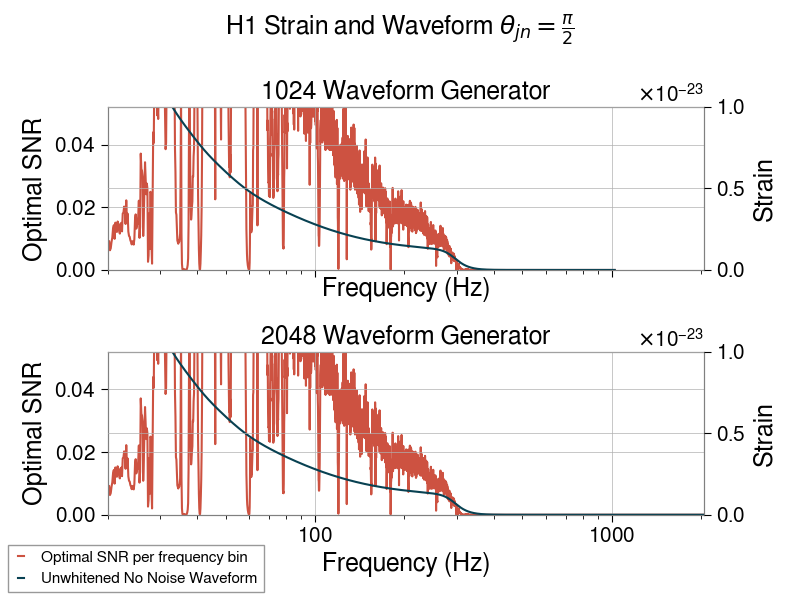

In [31]:
# Calculating SNR of injection
from bilby.gw.utils import noise_weighted_inner_product, optimal_snr_squared

fig, axes = plt.subplots(2, 1, figsize=(8,6), sharex=True)
fig.suptitle(r"H1 Strain and Waveform $\theta_{jn}= \frac{\pi}{2}$")

#y_max = 5.1e-3
y_max = 5.2e-2
y_max_wf = 1e-23
ax1 = axes[0]
ax1.set_title("1024 Waveform Generator")
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Optimal SNR")
ax1.set_ylim([0, y_max])
ax1.set_xlim([20, 2048])
ax1.set_xscale('log')
line_1, = ax1.plot(injection_generator_1024.data_domain.sample_frequencies, np.zeros(shape=injection_generator_1024.data_domain.sample_frequencies.shape[0]), label="Optimal SNR per frequency bin")
ax2 = ax1.twinx()
# ax2.set_yscale('log')
ax2.set_ylabel("Strain")
ax2.set_ylim([0, y_max_wf])
line_2, = ax2.plot(injection_generator_1024.data_domain.sample_frequencies, np.abs(strain_data_1024["waveform"]["H1"]), color=charizard_hex[1], label="Unwhitened No Noise Waveform")
fig.legend(loc=3, prop={'size': 11})

ax3 = axes[1]
ax3.set_title("2048 Waveform Generator")
ax3.set_xlabel("Frequency (Hz)")
ax3.set_ylabel("Optimal SNR")
ax3.set_ylim([0, y_max])
ax3.set_xlim([20, 2048])
ax3.set_xscale('log')
line_3, = ax3.plot(injection_generator_2048.data_domain.sample_frequencies, np.zeros(shape=injection_generator_2048.data_domain.sample_frequencies.shape[0]), label="Optimal SNR per frequency bin")
ax4 = ax3.twinx()
# ax4.set_yscale('log')
ax4.set_ylabel("Strain")
ax4.set_ylim([0, y_max_wf])
line_4, = ax4.plot(injection_generator_2048.data_domain.sample_frequencies, np.abs(strain_data_2048["waveform"]["H1"]), color=charizard_hex[1], label="Unwhitened No Noise Waveform")

fig.tight_layout()

fig.canvas.draw_idle()

def update(theta_jn):
    theta["theta_jn"] = theta_jn
    print(theta_jn)

    injection_generator_1024 = injection.Injection.from_posterior_model(main_pm_1024)
    injection_generator_1024.asd = asd
    strain_data_1024 = injection_generator_1024.signal(theta)

    injection_generator_2048 = injection.Injection.from_posterior_model(main_pm_2048)
    injection_generator_2048.asd = asd
    strain_data_2048 = injection_generator_2048.signal(theta)

    snrs_1024, freq_snr_squared_1024 = get_snr(injection_generator_1024, strain_data_1024)
    snrs_2048, freq_snr_squared_2048 = get_snr(injection_generator_2048, strain_data_2048)
    print(f"SNR 1024 {snrs_1024}   and SNR 2048 {snrs_2048}")
    opt_snr_1024 = np.sqrt(snrs_1024["H1"]**2 + snrs_1024["L1"]**2)
    opt_snr_2048 = np.sqrt(snrs_2048["H1"]**2 + snrs_2048["L1"]**2)
    print(f"Detector SNR 1024 {opt_snr_1024}   and SNR 2048 {opt_snr_2048}")

    print(type(line_1), line_1)
    line_1.set_ydata(freq_snr_squared_1024["H1"])
    line_2.set_ydata(np.abs(strain_data_1024["waveform"]["H1"]))
    line_3.set_ydata(freq_snr_squared_2048["H1"])
    line_4.set_ydata(np.abs(strain_data_2048["waveform"]["H1"]))
    fig.canvas.draw_idle()


interact(update, theta_jn=FloatSlider(min=0, max=np.pi, step=0.01, value=0.0, description=r'$\theta_{jn}$'))
plt.savefig("/home/local/nihargupte/dingo-devel/tutorials/05_data_vis/dumps/strain_and_snr.pdf")

0
SNR 1024 {'H1': (8.130922964453981243+0j), 'L1': (12.738957525292943006+0j)}   and SNR 2048 {'H1': (8.130922972573870554+0j), 'L1': (12.738957533573928379+0j)}
<class 'matplotlib.lines.Line2D'> Line2D(Optimal SNR per frequency bin)


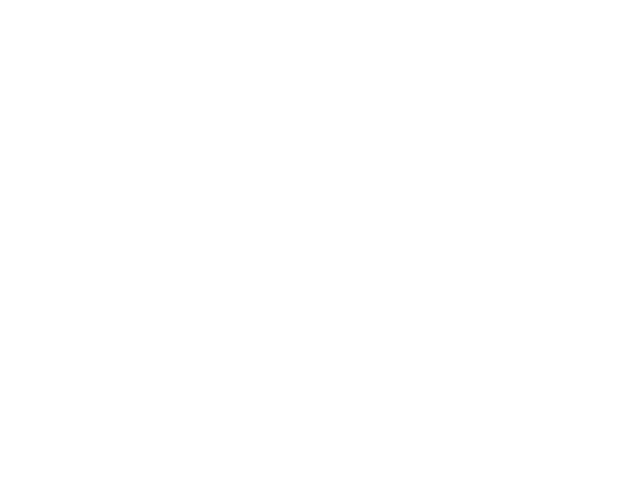

In [47]:
# Check SNR is working properly
# Bilby run @ pi, pi/2, and 0
%matplotlib ipympl # Set lowest mass dependent on what the lowest the network can do is
# Scale SNR to have SNR 8 at theta_jn = pi / 2
# Increase SNR since otherwise all will give u same network SNR = 25
# Check SNR function is working properly by comparison w/ bilby w/ IFO_LIST
# Important sweeps mass_ratio, theta_jn, effective_spin, total mass
update(0)
plt.savefig("/home/local/nihargupte/dingo-devel/tutorials/05_data_vis/dumps/strain_and_snr.pdf")

/home/local/nihargupte/dingo-devel/venv/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


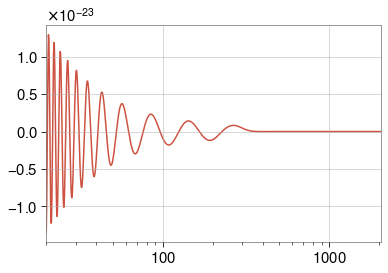

In [22]:
from bilby.gw.detector import InterferometerList
# Testing Bilby's Waveform Generator

time_duration = 8.0  # time duration (seconds)
sampling_frequency = 8192.0 # sampling frequency (Hz)

ifos = InterferometerList(["H1", "L1"])
ifos.set_strain_data_from_zero_noise(sampling_frequency, time_duration)

waveform_generator = bilby.gw.waveform_generator.WaveformGenerator(
    sampling_frequency=sampling_frequency,
    duration=time_duration,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    parameters=theta,
    waveform_arguments={"approximant": "SEOBNRv4HM_ROM", "f_ref": 20} ,
)
ifos.inject_signal(theta, waveform_generator=waveform_generator)

plt.xlim([20, 2048])
plt.xscale('log')
# plt.yscale('log')
plt.plot(ifos[0].frequency_array, ifos[0].strain_data.frequency_domain_strain)
